# Amazon Review NLP Analysis

## Import Packages

In [2]:
import io
import ijson
import pandas as pd
from pandas import DataFrame, Series
import datetime
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re 
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mord import LogisticAT
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

## Read and parse Json data to dataframe

In [47]:
cols = ["reviewerID", "asin", "reviewerName", "helpful_start",
        "helpful_end", "reviewText", "overall", "summary",
        "unixReviewTime", "reviewTime"]

reviewerID = []
asin = []
reviewerName = []
helpful_start = []
helpful_end = []
reviewText = []
overall = []
summary = []
unixReviewTime = []
reviewTime = []
helpful = []

a = datetime.datetime.now()

with open('reviews_electronics.8.json', encoding="UTF-8") as json_file:
    cursor = 0
    for line_number, line in enumerate(json_file):
        #print ("Processing line", line_number + 1,"at cursor index:", cursor)
        line_as_file = io.StringIO(line)
        # Use a new parser for each line
        json_parser = ijson.parse(line_as_file)
        for prefix, type, value in json_parser:
            if (type == 'string') | (type == 'number'):
                if prefix.strip() == 'reviewerID':
                    reviewerID.append(value)
                    #print(value)
                elif prefix.strip() == 'asin':
                    asin.append(value)
                elif prefix.strip() == 'reviewerName':
                    reviewerName.append(value)
                elif prefix.strip() == 'helpful.item':
                    helpful.append(value)
                elif prefix.strip() == 'reviewText':
                    reviewText.append(value)
                elif prefix.strip() == 'overall':
                    overall.append(value)
                elif prefix.strip() == 'summary':
                    summary.append(value)
                elif prefix.strip() == 'unixReviewTime':
                    unixReviewTime.append(value)
                elif prefix.strip() == 'reviewTime':
                    reviewTime.append(value)
        cursor += len(line)

        
b = datetime.datetime.now()
       
helpful_start = [helpful[i] for i in range(len(helpful)) if i%2 == 0]
helpful_end = [helpful[i] for i in range(len(helpful)) if i%2 == 1]

review = pd.DataFrame(list(zip(reviewerID, asin, reviewerName, helpful_start, helpful_end,
                           reviewText, overall, summary, unixReviewTime, reviewTime)),
               columns =cols)
c=b-a
print(c.seconds)

71


In [30]:
review.shape

(492359, 10)

In [65]:
review.head()

,reviewerID,asin,reviewerName,helpful_start,helpful_end,reviewText,overall,summary,unixReviewTime,reviewTime
0,AKM1MP6P0OYPR,0132793040,"Vicki Gibson ""momo4""",1,1,Corey Barker does a great job of explaining Bl...,5.0,Very thorough,1365811200,"04 13, 2013"
1,ANJ23S7YCEXXH,B003OSP4GA,"Skip Mueller ""Skip""",2,2,Unit is quite lightweight and cheap. Sound is...,2.0,You get what you pay for,1297209600,"02 9, 2011"
2,A7PD0NACTL19P,B003OSP4GA,S. Steele,7,7,This is a great player. The sound is good and ...,5.0,great product,1294531200,"01 9, 2011"
3,A23B5TZ8L89W0L,B003OSP4GA,"The Radical ""Rad""",9,10,"First, thank you to all the customers who post...",4.0,As promised...,1301184000,"03 27, 2011"
4,A26ER2O8Y96SJ6,B003OSPCJO,Alan F. Athearn,0,1,Because of negative reviews I tested it as soo...,5.0,Canon 500 Monopod,1334016000,"04 10, 2012"


## Data Preprocessing with NLTK

In [66]:
import nltk
#nltk.download()

**Convert to indicidual words and removing stop words**

In [67]:
review['reviewText'] = review['reviewText'].str.lower()

In [68]:
#split the review text into individual words
def identify_tokens(row):
    review = row['reviewText']
    tokens = nltk.word_tokenize(review)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

review['words'] = review.apply(identify_tokens, axis=1)

In [69]:
stops = set(stopwords.words("english"))                  

def remove_stops(row):
    my_list = row['words']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)

review['meaningful_words'] = review.apply(remove_stops, axis=1)

**Handle Negations**<br>
Split off the "n't" part from "xxxn't" into separate words "xxx" and "not". Attach all 'not's (any normal "not" appearing in the text as well as the "n't" converted to "not") to the subsequent word, eg "not_nextword" (code this yourself).

In [70]:
def remove_negation(row):
    my_list = row['meaningful_words']
    negation_words = [re.sub("n\'t | no | never |not ", ' not_',i) for i in my_list]
    return (negation_words)
review['meaningful_words'] = review.apply(remove_negation, axis=1)

**Stem all words using Porter 1979**

In [71]:
stemming = PorterStemmer()
def stem_list(row):
    my_list = row['meaningful_words']
    stem_list = [stemming.stem(word) for word in my_list]
    return (stem_list)

review['stem_meaningful'] = review.apply(stem_list, axis=1)

In [72]:
review.head()

,reviewerID,asin,reviewerName,helpful_start,helpful_end,reviewText,overall,summary,unixReviewTime,reviewTime,words,meaningful_words,stem_meaningful
0,AKM1MP6P0OYPR,0132793040,"Vicki Gibson ""momo4""",1,1,corey barker does a great job of explaining bl...,5.0,Very thorough,1365811200,"04 13, 2013","[corey, barker, does, a, great, job, of, expla...","[corey, barker, great, job, explaining, blend,...","[corey, barker, great, job, explain, blend, mo..."
1,ANJ23S7YCEXXH,B003OSP4GA,"Skip Mueller ""Skip""",2,2,unit is quite lightweight and cheap. sound is...,2.0,You get what you pay for,1297209600,"02 9, 2011","[unit, is, quite, lightweight, and, cheap, sou...","[unit, quite, lightweight, cheap, sound, ok, u...","[unit, quit, lightweight, cheap, sound, ok, un..."
2,A7PD0NACTL19P,B003OSP4GA,S. Steele,7,7,this is a great player. the sound is good and ...,5.0,great product,1294531200,"01 9, 2011","[this, is, a, great, player, the, sound, is, g...","[great, player, sound, good, works, great, pla...","[great, player, sound, good, work, great, play..."
3,A23B5TZ8L89W0L,B003OSP4GA,"The Radical ""Rad""",9,10,"first, thank you to all the customers who post...",4.0,As promised...,1301184000,"03 27, 2011","[first, thank, you, to, all, the, customers, w...","[first, thank, customers, posted, reviews, hel...","[first, thank, custom, post, review, help, pur..."
4,A26ER2O8Y96SJ6,B003OSPCJO,Alan F. Athearn,0,1,because of negative reviews i tested it as soo...,5.0,Canon 500 Monopod,1334016000,"04 10, 2012","[because, of, negative, reviews, i, tested, it...","[negative, reviews, tested, soon, arrived, mou...","[neg, review, test, soon, arriv, mount, canon,..."


**Create frequency count table and use the most frequent 500 words to define the word vector**


In [73]:
stem_meaningful = review['stem_meaningful'].tolist()
review_all=[y for x in stem_meaningful for y in x]
review_freq = nltk.FreqDist(review_all)
review_freq

FreqDist({'use': 284320, 'work': 257139, 'one': 190709, 'great': 174341, 'would': 155065, 'get': 144561, 'like': 141291, 'good': 139550, 'product': 126775, 'time': 110544, ...})

In [74]:
most_common_500 = pd.DataFrame(review_freq.most_common(500),columns=['words', 'count'])
most_common_500

,words,count
0,use,284320
1,work,257139
2,one,190709
3,great,174341
4,would,155065
...,...,...
495,lens,8673
496,later,8659
497,inch,8657
498,older,8636


**Create a bag-of-word vector representation for each review in electronics**

In [75]:
wordvec=most_common_500['words'].tolist()

In [76]:
bagOfWords = []
for doc in tqdm(stem_meaningful):
    bow = {word:0 for word in wordvec}
    for word in doc:
        if word in wordvec:
            bow[word] += 1
            
    bagOfWords.append(bow)

df_bagOfWords = pd.DataFrame(bagOfWords)

100%|██████████| 492359/492359 [03:31<00:00, 2328.82it/s]


In [77]:
df_bagOfWords.head()

,use,work,one,great,would,get,like,good,product,time,...,believ,improv,area,write,break,lens,later,inch,older,backup
0,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,2,0,0,2,1,1,0,1,...,0,0,0,0,2,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Identify difference between reviews using Euclidian distance

In [26]:
# calculate the distance between first 100 reviews
first_100_bow=df_bagOfWords[:100]
euclidean_distance_df = pd.DataFrame(euclidean_distances(first_100_bow,first_100_bow),columns = review['reviewerID'].iloc[:100],index = review['reviewerID'].iloc[:100])
euclidean_distance_df

reviewerID,AKM1MP6P0OYPR,ANJ23S7YCEXXH,A7PD0NACTL19P,A23B5TZ8L89W0L,A26ER2O8Y96SJ6,AEUCIUFQ96ASG,A2ZND6EBWK26P3,A3HBLEFW3MRB28,APDN9X94747NX,A35JTKP5I1O2NJ,...,A13C8DDMIBHK8G,AFANKEQRSWGGY,A2FTDSUXPFOSCG,A1FM6LJAJVBWB3,A2N2PJLAVS6TSJ,A1QYZ8RV9Q9KDO,A2JH9W82AAVCKY,A3EXTAK2ZZLXAU,A3BHPD32RSZJQX,A2686Q1LBBY1VL
reviewerID,,,,,,,,,,,,,,,,,,,,,
AKM1MP6P0OYPR,0.000000,6.082763,4.000000,11.832160,6.082763,6.244998,5.196152,6.782330,5.000000,6.708204,...,5.744563,4.582576,6.782330,5.916080,5.744563,4.582576,4.690416,7.549834,6.000000,4.582576
ANJ23S7YCEXXH,6.082763,0.000000,5.744563,11.090537,6.928203,7.615773,6.928203,7.681146,6.480741,8.124038,...,6.782330,6.000000,7.416198,7.071068,6.928203,5.830952,6.082763,7.874008,6.855655,6.000000
A7PD0NACTL19P,4.000000,5.744563,0.000000,11.489125,6.082763,6.557439,5.385165,6.928203,5.196152,7.000000,...,5.567764,4.582576,7.211103,6.082763,5.916080,4.795832,4.690416,7.549834,6.164414,5.000000
A23B5TZ8L89W0L,11.832160,11.090537,11.489125,0.000000,12.206556,11.958261,11.874342,12.328828,12.288206,12.688578,...,11.874342,11.958261,12.083046,12.206556,12.041595,11.789826,12.000000,13.000000,12.247449,11.958261
A26ER2O8Y96SJ6,6.082763,6.928203,6.082763,12.206556,0.000000,7.348469,6.324555,6.244998,6.324555,7.483315,...,6.164414,5.656854,6.244998,5.830952,6.480741,5.830952,5.567764,6.633250,6.557439,5.830952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A1QYZ8RV9Q9KDO,4.582576,5.830952,4.795832,11.789826,5.830952,6.324555,5.477226,6.244998,4.898979,6.782330,...,5.656854,4.242641,6.082763,6.000000,5.099020,0.000000,4.582576,6.928203,5.385165,4.000000
A2JH9W82AAVCKY,4.690416,6.082763,4.690416,12.000000,5.567764,6.403124,5.385165,6.164414,5.196152,6.708204,...,5.000000,4.358899,7.071068,5.744563,5.385165,4.582576,0.000000,6.855655,6.000000,4.795832
A3EXTAK2ZZLXAU,7.549834,7.874008,7.549834,13.000000,6.633250,8.000000,7.615773,7.549834,7.483315,8.485281,...,7.071068,7.211103,7.810250,7.348469,7.211103,6.928203,6.855655,0.000000,7.549834,6.782330


In [27]:
dist_array = euclidean_distance_df.values
# get the unrepeated dist into a list
first_review_no=[]
second_review_no=[]
first_100_dist=[]
for i in range(1,100):
    for j in range(i+1,100):
        first_review_no.append(i)
        second_review_no.append(j)
        first_100_dist.append(dist_array[i,j])

In [28]:
first_100_dist=DataFrame({"first_review_number":first_review_no,"second_review_number":second_review_no,"distance":first_100_dist})
first_100_dist = first_100_dist.sort_values(by = 'distance', ascending = True)
first_100_dist.head()

,first_review_number,second_review_number,distance
2194,26,71,2.828427
1237,14,56,2.828427
1235,14,54,3.000000
4609,77,89,3.000000
3917,56,69,3.000000


## Identify Principal components of all reviews using PCA.

In [29]:
scaler = StandardScaler()
X = np.array(first_100_bow)
X_trans=scaler.fit_transform(X)

In [30]:
first_100_pca = PCA(n_components=2).fit(X_trans)
print(first_100_pca.explained_variance_ratio_)
print(first_100_pca.singular_values_)

[0.08192231 0.05422841]
[56.59648701 46.0470523 ]


In [31]:
pca_df = pd.DataFrame(first_100_pca.transform(X_trans),columns = ['PC1', 'PC2'])

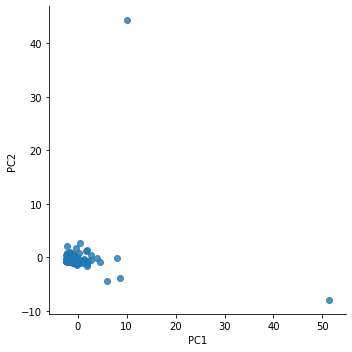

In [32]:
#plot
sns.lmplot( x="PC1", y="PC2",
  data=pca_df, 
  fit_reg=False, 
  legend=True)

## Use ordinal lasso logistic regression to predict the 5-star rating with reviews.

In [78]:
review['overall'].value_counts()

5.0    274338
4.0     90422
1.0     58342
3.0     39826
2.0     29431
Name: overall, dtype: int64

In [79]:
### method: use the ordianl logistic regression 
X_logit = df_bagOfWords
y = review['overall'].astype(int)

In [80]:
#train test split of 70/30 ratio
X_train,X_test,y_train,y_test=train_test_split(X_logit,y, test_size=0.7, random_state=31)

In [81]:
#alpha=1 to set to train the lasso logistic regression. 
log_ordinal = LogisticAT(alpha=1)
log_ordinal.fit(X_train, y_train)

LogisticAT(alpha=1, max_iter=1000, verbose=0)

In [82]:
y_predict=log_ordinal.predict(X_test)

In [83]:
#calculate the out of sample accuracy score. 
accuracy=accuracy_score(y_test, y_predict)

In [84]:
print('The out of sample accuracy score of ordinal logistic model is ', accuracy)

The out of sample accuracy score of ordinal logistic model is  0.538218260738368


## Aggregate reviews by product ASIN

In [19]:
##aggregate by product
df_bagOfWords['asin']=review['asin']
product_review=df_bagOfWords.groupby('asin').sum()

In [21]:
product_review.head()

,use,work,one,great,would,get,like,good,product,time,...,believ,improv,area,write,break,lens,later,inch,older,backup
asin,,,,,,,,,,,,,,,,,,,,,
0132793040,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B003OSP4GA,2,2,2,2,1,2,2,2,0,2,...,0,0,0,0,2,0,0,0,0,0
B003OSPCJO,83,32,25,27,44,16,35,23,28,21,...,1,5,1,0,5,4,4,4,0,0
B003OSPEXI,1,0,2,0,5,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
B003OSPOO2,2,1,1,0,4,2,2,2,0,0,...,0,0,0,0,0,4,0,0,0,0


## Measure the distance between different product 

In [32]:
product_review=product_review.reset_index()

In [43]:
#Calculate the euclidean distance of between each product
euclidean_distance_product = pd.DataFrame(euclidean_distances(product_review.iloc[:,1:],product_review.iloc[:,1:]),columns = product_review['asin'],index = product_review['asin'])
euclidean_distance_product

asin,0132793040,B003OSP4GA,B003OSPCJO,B003OSPEXI,B003OSPOO2,B003OSPSA2,B003OSQ8CO,B003OSR6E8,B003OSRGTS,B003OSRGZM,...,B004ARA17Q,B004ARA8JC,B004ARDTZ2,B004ARFC5C,B004ARIVEQ,B004ARJ51Y,B004ARM27S,B004ARMQTM,B004ARP28O,B004ARQFZI
asin,,,,,,,,,,,,,,,,,,,,,
0132793040,0.000000,15.329710,212.572341,13.379088,18.193405,4.795832,14.142136,374.613134,10.816654,21.400935,...,4.582576,10.148892,4.898979,12.124356,9.273618,9.000000,11.401754,17.000000,16.613248,39.230090
B003OSP4GA,15.329710,0.000000,208.561741,18.000000,21.633308,15.231546,18.681542,371.693422,16.852300,23.043437,...,15.684387,16.852300,15.394804,17.492856,16.522712,16.673332,16.583124,20.688161,20.124612,36.932371
B003OSPCJO,212.572341,208.561741,0.000000,209.776071,205.333874,211.976414,207.848503,346.903445,210.033331,205.253502,...,212.922521,210.817457,212.040091,209.198470,211.601040,209.035882,209.644938,205.416650,208.559344,199.624648
B003OSPEXI,13.379088,18.000000,209.776071,0.000000,20.199010,13.114877,17.521415,372.537246,15.362291,22.293497,...,13.341664,15.427249,13.152946,16.673332,15.198684,14.071247,16.155494,19.339080,19.104973,37.549967
B003OSPOO2,18.193405,21.633308,205.333874,20.199010,0.000000,18.000000,17.175564,370.928565,19.798990,24.228083,...,18.384776,19.748418,18.083141,18.920888,19.157244,15.811388,20.074860,22.803509,22.912878,39.824616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B004ARJ51Y,9.000000,16.673332,209.035882,14.071247,15.811388,8.485281,13.964240,373.183601,12.489996,21.283797,...,8.944272,12.083046,8.544004,13.341664,11.445523,0.000000,13.152946,16.911535,17.000000,38.652296
B004ARM27S,11.401754,16.583124,209.644938,16.155494,20.074860,11.532563,15.811388,372.441942,13.747727,21.354157,...,11.789826,11.180340,11.832160,14.525839,11.401754,13.152946,0.000000,18.520259,15.684387,37.134889
B004ARMQTM,17.000000,20.688161,205.416650,19.339080,22.803509,16.792856,20.518285,365.789557,18.110770,23.515952,...,17.088007,18.110770,16.643317,19.339080,18.248288,16.911535,18.520259,0.000000,21.000000,38.548671
